# Generating music with GTZAN and Keras
Let's generate some music! A lot of techniques I've seen around use symbolic methods (generate tabs / midi), but I think giving the model full control over the waveform is a lot more challenging and potentially a lot more fun / cooler. The model architecture I'll be using is very inspired by [this awesome example in the keras docs](https://keras.io/examples/generative/ddim/), which I highly recommend taking a look at if you want to learn more about diffusion models

Let's start off by pinning our version of librosa so that our logs look reasonable (skip this step at your own risk)

# Explanation of technique
Skip this part if you don't like reading 😆. The overall idea here is to generate music directly from spectrograms (or some kind of 2d representation of the audio data) and then convert the spectrogram back to audio.

### Feature representation
I consider this to be the crux of this whole technique. Because image generation with CNNs is very popular and has been super successful recently (especially with the explosive progress made recently with diffusion models). The way I use the audio data is by using a [Modified Discrete Cosine Transform (MDCT)](https://www.tensorflow.org/api_docs/python/tf/signal/mdct). Using this particular transform is useful because you can exactly reconstruct your audio waveform from the MDCT spectrogram by applying the inverse MDCT transform. It's also useful because, unlike the fourier transform, all of the values that come from the MDCT transform are real valued. That way, you don't have to fool around with trying to reconstruct the phase of your new signal. This is what allows us to take advantage of 2d convolutional neural networks in order to create a 2d spectrogram and convert it directly to audio.  

### Model Architecture
I chose U-net, mostly because it seems to be the standard choice for training Diffusion models. I add attention in the bottom upsampling layer. Would be cool to try adding attention to more parts of this model and see how it affects the generated examples. I've intended to, but tend to OOM the GPU when I do. Happy to hear suggestions.

### Training & Sampling
In my own personal experiments, I've tried a few different generative models for this task. This includes several types of GAN and VAE models. It seems like diffusion works (by far) much better. I (once again) borrow [this implementation of Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/) (seriously, take a read if you're interested. I find it to be very practical and digestable). I pretty arbitrarily choose 1000 diffusion steps for sampling. Maybe more is better? Maybe less? Worth playing with more

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install librosa==0.8.0
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 183 kB 15.8 MB/s 
  Created wheel for librosa: filename=librosa-0.8.0-py3-none-any.whl size=201396 sha256=da337f67fd67db6ea28092bbd4cbe1c945e31b0c6e583792a485d989f9009661
  Stored in directory: /root/.cache/pip/wheels/aa/5a/92/d52f6f8560ff05a2525e6030a1903412df876714241fb76802
Successfully built librosa
  Attempting uninstall: librosa
    Found existing installation: librosa 0.8.1
    Uninstalling librosa-0.8.1:
      Successfully uninstalled librosa-0.8.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 15.3 MB/s 


In [3]:
import math
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import sys
from glob import glob

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub

import librosa 
import soundfile as sf

import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import partial
import warnings
import IPython.display as ipd
warnings.filterwarnings('ignore')

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Let's try using magenta's spectrogram inversion model!

In [30]:
module = hub.KerasLayer('https://tfhub.dev/google/soundstream/mel/decoder/music/1')

SAMPLE_RATE = 16000
N_FFT = 1024
HOP_LENGTH = 320
WIN_LENGTH = 640
N_MEL_CHANNELS = 128
MEL_FMIN = 0.0
MEL_FMAX = int(SAMPLE_RATE // 2)
CLIP_VALUE_MIN = 1e-5
CLIP_VALUE_MAX = 1e8

MEL_BASIS = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=N_MEL_CHANNELS,
    num_spectrogram_bins=N_FFT // 2 + 1,
    sample_rate=SAMPLE_RATE,
    lower_edge_hertz=MEL_FMIN,
    upper_edge_hertz=MEL_FMAX)

def calculate_spectrogram(samples):
    """Calculate mel spectrogram using the parameters the model expects."""
    fft = tf.signal.stft(
      samples,
      frame_length=WIN_LENGTH,
      frame_step=HOP_LENGTH,
      fft_length=N_FFT,
      window_fn=tf.signal.hann_window,
      pad_end=True)
    fft_modulus = tf.abs(fft)

    output = tf.matmul(fft_modulus, MEL_BASIS)

    output = tf.clip_by_value(
      output,
      clip_value_min=CLIP_VALUE_MIN,
      clip_value_max=CLIP_VALUE_MAX)
    output = tf.math.log(output)
    return output


## Pick some files to train on

I've found that this doesn't work so well if you try to train the model on all genres at once. So let's pick a single genre. I'll pick classical for now

In [6]:
music_files = glob("/content/drive/MyDrive/PGM Project/test_data/Data/genres_original/classical/classical.*.wav")
music_files[:10]

['/content/drive/MyDrive/PGM Project/test_data/Data/genres_original/classical/classical.00003.wav',
 '/content/drive/MyDrive/PGM Project/test_data/Data/genres_original/classical/classical.00004.wav',
 '/content/drive/MyDrive/PGM Project/test_data/Data/genres_original/classical/classical.00001.wav',
 '/content/drive/MyDrive/PGM Project/test_data/Data/genres_original/classical/classical.00002.wav',
 '/content/drive/MyDrive/PGM Project/test_data/Data/genres_original/classical/classical.00005.wav',
 '/content/drive/MyDrive/PGM Project/test_data/Data/genres_original/classical/classical.00000.wav',
 '/content/drive/MyDrive/PGM Project/test_data/Data/genres_original/classical/classical.00007.wav',
 '/content/drive/MyDrive/PGM Project/test_data/Data/genres_original/classical/classical.00015.wav',
 '/content/drive/MyDrive/PGM Project/test_data/Data/genres_original/classical/classical.00012.wav',
 '/content/drive/MyDrive/PGM Project/test_data/Data/genres_original/classical/classical.00016.wav']

In [7]:
data, sr = librosa.load(music_files[1], sr=SAMPLE_RATE)

In [8]:
data.shape, sr

((480214,), 16000)

In [9]:
ipd.Audio(data[:int(sr*5.12)], rate=sr)

In [ ]:
# import soundfile as sf
# %cd /content/drive/MyDrive/
# sf.write('real/tone1.wav', data[:int(sr*5.12)], sr)

In [31]:
calculate_spectrogram(data[:(int(sr*5.12))])

<tf.Tensor: shape=(256, 128), dtype=float32, numpy=
array([[-0.93867415, -0.5679678 , -0.36506563, ..., -3.870099  ,
        -5.4692826 , -7.108475  ],
       [-1.2385919 , -1.2237064 , -1.0489125 , ..., -3.5461965 ,
        -5.4848304 , -7.0997615 ],
       [-0.8563534 , -0.34327212, -0.14360763, ..., -3.6197174 ,
        -5.5624585 , -7.1622868 ],
       ...,
       [ 0.19423807,  0.40366963,  0.5767686 , ..., -3.941096  ,
        -4.578943  , -7.3029056 ],
       [-0.65518975, -0.97780406,  0.08467796, ..., -4.306156  ,
        -5.1498685 , -7.2890697 ],
       [-1.6141233 , -1.0909716 , -0.8358758 , ..., -1.7874775 ,
        -1.7843878 , -1.7859368 ]], dtype=float32)>

In [32]:
reconstructed_samples = module([calculate_spectrogram(data)])

In [33]:
reconstructed_samples.shape, data.shape

(TensorShape([1, 480320]), (480214,))

In [34]:
ipd.Audio(reconstructed_samples[0,:int(sr*5.12)], rate=sr)

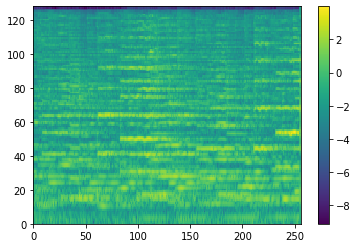

In [35]:
plt.pcolormesh(calculate_spectrogram(data[:int(sr*5.12)]).numpy().T)
plt.colorbar()

## Define keras layers
Define the layers we'll use to build our model.

In [10]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    embedding_max_frequency = 1000.0
    embedding_dims = 32
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth, attention=False):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            skip = skips.pop()
            x = layers.Concatenate()([x, skip] if not attention else [
                x, skip, layers.MultiHeadAttention(
                    num_heads=4, key_dim=1, attention_axes=(1, 2)
                )(x, skip)
            ])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(widths, block_depth, dim1=256, dim2=128, channels=1, attention=False):
    noisy_input = keras.Input(shape=(dim1, dim2, channels))
    noise_variances = keras.Input(shape=(1, 1, 1))
    
    upsample_shape = (dim1, dim2)

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=upsample_shape, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_input)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for idx, width in enumerate(reversed(widths[:-1])):
        x = UpBlock(width, block_depth, attention=attention and idx == 0)([x, skips])

    x = layers.Conv2D(channels, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_input, noise_variances], x, name="residual_unet")

## Define Model
Here, we'll build our model

In [11]:
min_signal_rate = 0.02
max_signal_rate = 0.95
ema = 0.999

class DDIM(keras.Model):
    """DDIM model modified from this tutorial: https://keras.io/examples/generative/ddim/"""
    
    def __init__(self, widths, block_depth, attention=False, dim1=256, dim2=128):
        super().__init__()

        self.normalizer = layers.Normalization(axis=(2,3))
        self.network = get_network(widths, block_depth, attention=attention, dim1=dim1, dim2=dim2)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="noise_loss")
        self.data_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.data_loss_tracker]

    def denormalize(self, data):
        data = self.normalizer.mean + data * self.normalizer.variance**0.5
        return tf.clip_by_value(data, -128.0, 128.0)

    def diffusion_schedule(self, diffusion_times):
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)
        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        return noise_rates, signal_rates

    def denoise(self, noisy_data, noise_rates, signal_rates, training):
        if training:
            network = self.network
        else:
            network = self.ema_network
        pred_noises = network([noisy_data, noise_rates**2], training=training)
        pred_data = (noisy_data - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_data

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_examples = tf.shape(initial_noise)[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy data" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_data = initial_noise
        for step in tqdm(range(diffusion_steps)):
            noisy_data = next_noisy_data

            # separate the current noisy data to its components
            diffusion_times = tf.ones((num_examples, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_data = self.denoise(
                noisy_data, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_data = (
                next_signal_rates * pred_data + next_noise_rates * pred_noises
            )
            # this new noisy data will be used in the next step

        return pred_data

    def generate(self, num_examples, shape, diffusion_steps):
        # noise -> data -> denormalized data
        initial_noise = tf.random.normal(shape=(num_examples, shape[0], shape[1], shape[2]))
        generated_data = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_data = self.denormalize(generated_data)
        return generated_data

    def train_step(self, data):
        batch_size = tf.shape(data)[0]
        # normalize data to have standard deviation of 1, like the noises
        data = self.normalizer(data, training=True)
        noises = tf.random.normal(shape=tf.shape(data))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the data with noises accordingly
        noisy_data = signal_rates * data + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy data to their components
            pred_noises, pred_data = self.denoise(
                noisy_data, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            data_loss = self.loss(data, pred_data)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.data_loss_tracker.update_state(data_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        # normalize data to have standard deviation of 1, like the noises
        batch_size = tf.shape(data)[0]
        
        data = self.normalizer(data, training=False)
        noises = tf.random.normal(shape=tf.shape(data))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the data with noises accordingly
        noisy_data = signal_rates * data + noise_rates * noises

        # use the network to separate noisy data to their components
        pred_noises, pred_data = self.denoise(
            noisy_data, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        data_loss = self.loss(data, pred_data)

        self.data_loss_tracker.update_state(data_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        return {m.name: m.result() for m in self.metrics}

## Define data loader

Here we're going to make some data loading utils and then define our dataset

In [12]:
def load_at_interval(x, rate=10_000, feats=256, duration=3.3):
    """Load music from file at some offset. Return MDCT spectrogram of that data"""
    file = x[0].numpy().decode()
    idx = x[1].numpy()
    audio, sr = librosa.load(file, duration=duration, sr=rate, offset=idx)
    audio_fill = np.zeros(int(rate*duration), dtype=np.float32)
    audio_fill[:len(audio)] = audio
    spec = calculate_spectrogram(audio_fill)#spec = tf.signal.mdct(audio_fill, feats)
    return spec

def load_audio(x,y, rate=10_000, mdct_feats=256, duration=3.3):
    """TF function for loading MDCT spectrogram from file."""
    out = tf.py_function(lambda x,y: load_at_interval( 
        (x,y), rate=rate, feats=mdct_feats, duration=duration
    ), inp=[x,y], Tout=tf.float32)
    return out

def get_files_dataset(
        glob_location,
        total_seconds=2,
        out_len = 5.12,
        hop_size=1,
        max_feats = 2048,
        batch_size=4,
        shuffer_size=1000,
        scale=1,
        rate=16_000,
        mdct_feats=256
    ):
    """Get file dataset loader for a glob of audio files."""
    
    files = glob(
        glob_location,
        recursive=True
    )
    
    def file_list_generator():
        for _ in range(total_seconds):
            for file in files:
                yield file, _*hop_size
                
    load_fn = partial(load_audio, duration=out_len, rate=rate, mdct_feats=mdct_feats)
                
    dg =tf.data.Dataset.from_generator(file_list_generator, output_signature = (
        tf.TensorSpec(shape=(), dtype=tf.string), 
        tf.TensorSpec(shape=(), dtype=tf.int32))).shuffle(shuffer_size).map(
            load_fn, num_parallel_calls=tf.data.AUTOTUNE
        ).map(
            lambda x: tf.expand_dims(x, -1)[:max_feats, :, :]*scale
        ).map(
            lambda x: tf.ensure_shape(x, (max_feats, mdct_feats//2, 1))
        ).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dg

## Putting it all together

In [13]:
dataset = get_files_dataset(
    "/content/drive/MyDrive/PGM Project/test_data/Data/genres_original/classical/classical.00000.wav", 
    out_len=5.12, 
    max_feats=256, 
    total_seconds=20, 
    scale=1,
    batch_size=1
)

In [14]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [15]:
dataset.take(1)

<TakeDataset element_spec=TensorSpec(shape=(None, 256, 128, 1), dtype=tf.float32, name=None)>

In [16]:
for test_batch in dataset.take(1):
  shape = test_batch.shape

print(shape)

(1, 256, 128, 1)


In [17]:
num_total_examples = (len(music_files) * 25) // shape[0]

In [18]:
model = DDIM(widths = [32, 64, 96, 128], block_depth = 2, attention=True, dim1=shape[1], dim2=shape[2])

In [19]:
model.normalizer.adapt(dataset, steps=100)

In [20]:
model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tfa.optimizers.AdamW(
        learning_rate = 3e-4,
        weight_decay = 1e-4
    )
)

In [21]:
dataset = dataset.cache()

## Model Training

In [22]:
history = model.fit(dataset.repeat(), steps_per_epoch=num_total_examples, epochs=1)

2500/2500 [==============================] - 2362s 943ms/step - noise_loss: 0.1657 - reconstruction_loss: 0.7094


## Generate new samples using this model

In [23]:
specs = model.generate(5, shape[1:], 5)

100%|██████████| 5/5 [00:08<00:00,  1.67s/it]


In [27]:
specs.shape

TensorShape([5, 256, 128, 1])

In [28]:
test_batch.shape

TensorShape([1, 256, 128, 1])

## Saving the Model

In [ ]:
EXPERIMENT_NAME = "test_save_model"

log_dir = f"/content/drive/MyDrive/PGM Project/saved_experiments/{EXPERIMENT_NAME}"
model_path = f'{log_dir}/saved_model'
model.save_weights(model_path, save_format='tf')

### Saving Training Loss History

In [ ]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
# save to csv: 
hist_csv_file = f'{log_dir}/result_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

## Load a Saved Model

In [ ]:
EXPERIMENT_NAME = "test_save_model"

log_dir = f"/content/drive/MyDrive/PGM Project/saved_experiments/{EXPERIMENT_NAME}"
load_model_path = f'{log_dir}/saved_model'

In [ ]:
loaded_model = DDIM(widths = [32, 64, 96, 128], block_depth = 2, attention=True, dim1=shape[1], dim2=shape[2])
loaded_model.normalizer.adapt(dataset, steps=100)

In [ ]:
load_status = loaded_model.load_weights(model_path)

In [ ]:
# loaded_model.generate(5, shape[1:], 5)

## Let's look at some real examples first, to get an idea of what we're looking for

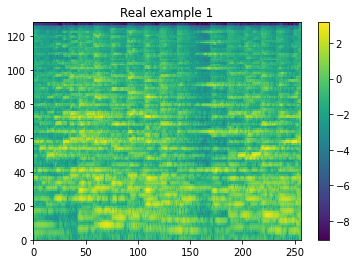

In [37]:
for i in range(1):
    plt.pcolormesh(test_batch[i, :, :, 0].numpy().T)
    plt.colorbar()
    plt.title(f"Real example {i+1}")
    plt.show()
    ipd.display(ipd.Audio(module( [test_batch[i, :, :, 0]]) , rate=16_000))

### Now let's compare the generated samples

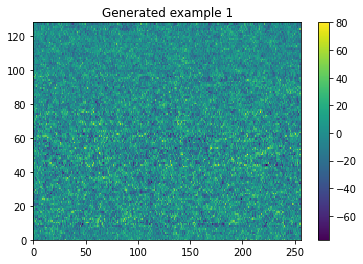

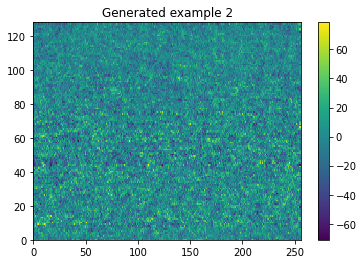

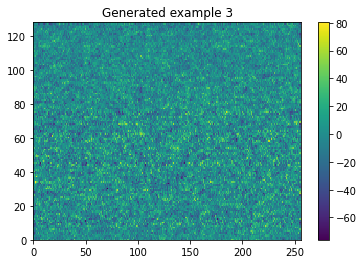

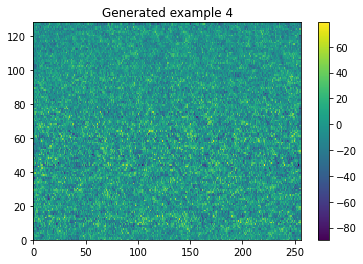

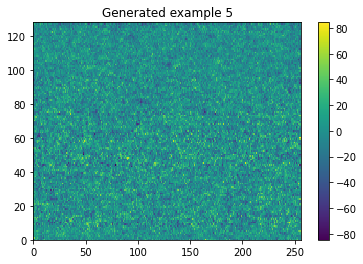

In [38]:
for i in range(len(specs)):
    plt.pcolormesh(specs[i, :, :, 0].numpy().T)
    plt.colorbar()
    plt.title(f"Generated example {i+1}")
    plt.show()
    ipd.display(ipd.Audio(module([specs[i, :, :, 0]]), rate=16_000))

## Saving the generations

In [68]:
EXPERIMENT_NAME = "test_save_model"

RESULT_DIR = "/content/drive/MyDrive/PGM Project/SpectrogramDiffusionResults"
model_results_path = f"{RESULT_DIR}/generated/{EXPERIMENT_NAME}"

#create the director if it doesnt exist already
if os.path.exists(model_results_path) == False:
  os.mkdir(model_results_path)

for i in range(len(specs)):
  print(i)
  sf.write(f'{model_results_path}/tone{i}.wav', module([specs[i, :, :, 0]]).numpy().T, SAMPLE_RATE)

0
1
2
3
4


# Evaluation Metrics

## FAD

In [52]:
!git clone https://github.com/gudgud96/frechet-audio-distance.git

Cloning into 'frechet-audio-distance'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 27 (delta 10), reused 21 (delta 6), pack-reused 0
Unpacking objects: 100% (27/27), done.


In [62]:
pip install frechet_audio_distance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
# import sys
# sys.path.append("/content/frechet-audio-distance")
from frechet_audio_distance import FrechetAudioDistance

In [71]:
pred_path = f"/content/drive/MyDrive/PGM Project/SpectrogramDiffusionResults/generated/{EXPERIMENT_NAME}"
gt_path = f"/content/drive/MyDrive/PGM Project/SpectrogramDiffusionResults/real"

In [72]:
frechet = FrechetAudioDistance(
    use_pca=False, 
    use_activation=False,
    verbose=False
)
fad_score = frechet.score(pred_path, gt_path)

Using cache found in /root/.cache/torch/hub/harritaylor_torchvggish_master


In [73]:
fad_score

31.94364138932103

### Mir_eval Tests

In [ ]:
# !git clone https://github.com/craffel/mir_eval.git

In [ ]:
# !pip install mir_eval

In [ ]:
# !pip install nose

In [ ]:
import sys
sys.path.append("/content/mir_eval/tests/")
from test_transcription import *

In [ ]:
gt = test_batch[0, :, :, 0].numpy()
gt.shape

(256, 128)

In [ ]:
pred = specs[0, :, :, 0].numpy()
pred.shape

(256, 128)

In [ ]:
# WHAT ON EARTH IS THIS!!
SCORES = {
    "Precision": 0.4,
    "Recall": 0.5,
    "F-measure": 0.4444444444444445,
    "Average_Overlap_Ratio": 0.675,
    "Precision_no_offset": 0.6,
    "Recall_no_offset": 0.75,
    "F-measure_no_offset": 0.6666666666666665,
    "Average_Overlap_Ratio_no_offset": 0.5833333333333333
}


In [ ]:
import mir_eval
# load test data
ref_int, ref_pitch = gt[:, :127], gt[:, 127]
est_int, est_pitch = pred[:, :127], pred[:, 127]

precision, recall, f_measure, avg_overlap_ratio = (
    mir_eval.transcription.precision_recall_f1_overlap(
        ref_int, ref_pitch, est_int, est_pitch))

scores_gen = np.array([precision, recall, f_measure, avg_overlap_ratio])
scores_exp = np.array([SCORES['Precision'], SCORES['Recall'],
                        SCORES['F-measure'],
                        SCORES['Average_Overlap_Ratio']])
assert np.allclose(scores_exp, scores_gen, atol=1e-12)

precision, recall, f_measure, avg_overlap_ratio = (
    mir_eval.transcription.precision_recall_f1_overlap(
        ref_int, ref_pitch, est_int, est_pitch, offset_ratio=None))

ValueError: ignored

### MT3 stuff

In [ ]:
# # Copyright 2021 Google LLC. All Rights Reserved.

# # Licensed under the Apache License, Version 2.0 (the "License");
# # you may not use this file except in compliance with the License.
# # You may obtain a copy of the License at

# #     http://www.apache.org/licenses/LICENSE-2.0

# # Unless required by applicable law or agreed to in writing, software
# # distributed under the License is distributed on an "AS IS" BASIS,
# # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# # See the License for the specific language governing permissions and
# # limitations under the License.
# # ==============================================================================

# #@title Setup Environment
# #@markdown Install MT3 and its dependencies (may take a few minutes).

# !apt-get update -qq && apt-get install -qq libfluidsynth1 build-essential libasound2-dev libjack-dev

# !pip install nest-asyncio
# # pin pyfluidsynth to avoid weird octave issue
# !pip install pyfluidsynth==1.3.0
# # pin CLU for python 3.7 compatibility
# !pip install clu==0.0.7
# # pin Orbax to use Checkpointer
# !pip install orbax==0.0.2

# # install t5x
# !git clone --branch=main https://github.com/google-research/t5x
# # pin T5X for python 3.7 compatibility
# !cd t5x; git reset --hard 2e05ad41778c25521738418de805757bf2e41e9e; cd ..
# !mv t5x t5x_tmp; mv t5x_tmp/* .; rm -r t5x_tmp
# !sed -i 's:jax\[tpu\]:jax:' setup.py
# !python3 -m pip install -e .

# # install mt3
# !git clone --branch=main https://github.com/magenta/mt3
# !mv mt3 mt3_tmp; mv mt3_tmp/* .; rm -r mt3_tmp
# !python3 -m pip install -e .

# # downgrade jax
# # TODO(iansimon): remove this once we can use the latest t5x
# !pip install jax[cuda]==0.3.15 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# # copy checkpoints
# !gsutil -q -m cp -r gs://mt3/checkpoints .

# # copy soundfont (originally from https://sites.google.com/site/soundfonts4u)
# !gsutil -q -m cp gs://magentadata/soundfonts/SGM-v2.01-Sal-Guit-Bass-V1.3.sf2 .

# import json
# import IPython

# # The below functions (load_gtag and log_event) handle Google Analytics event
# # logging. The logging is anonymous and stores only very basic statistics of the
# # audio and transcription e.g. length of audio, number of transcribed notes.

# def load_gtag():
#   """Loads gtag.js."""
#   # Note: gtag.js MUST be loaded in the same cell execution as the one doing
#   # synthesis. It does NOT persist across cell executions!
#   html_code = '''
# <!-- Global site tag (gtag.js) - Google Analytics -->
# <script async src="https://www.googletagmanager.com/gtag/js?id=UA-80107903-6"></script>
# <script>
#   window.dataLayer = window.dataLayer || [];
#   function gtag(){dataLayer.push(arguments);}
#   gtag('js', new Date());
#   gtag('config', 'UA-80107903-6',
#        {'referrer': document.referrer.split('?')[0],
#         'anonymize_ip': true,
#         'page_title': '',
#         'page_referrer': '',
#         'cookie_prefix': 'magenta',
#         'cookie_domain': 'auto',
#         'cookie_expires': 0,
#         'cookie_flags': 'SameSite=None;Secure'});
# </script>
# '''
#   IPython.display.display(IPython.display.HTML(html_code))

# def log_event(event_name, event_details):
#   """Log event with name and details dictionary."""
#   details_json = json.dumps(event_details)
#   js_string = "gtag('event', '%s', %s);" % (event_name, details_json)
#   IPython.display.display(IPython.display.Javascript(js_string))

# load_gtag()
# log_event('setupComplete', {})

In [ ]:
!git clone https://github.com/magenta/mt3.git

Cloning into 'mt3'...
remote: Enumerating objects: 296, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 296 (delta 40), reused 55 (delta 27), pack-reused 193
Receiving objects: 100% (296/296), 172.74 KiB | 11.52 MiB/s, done.
Resolving deltas: 100% (165/165), done.


In [ ]:
#@title Imports and Definitions

import functools
import os

import numpy as np
import tensorflow.compat.v2 as tf

import functools
import gin
import jax
import librosa
import note_seq
import seqio
import t5
import t5x
sys.path.append("/content/mt3/mt3")
import metrics_utils
import models
import network
import note_sequences
import preprocessors
import spectrograms
import vocabularies

from google.colab import files

import nest_asyncio
nest_asyncio.apply()

SAMPLE_RATE = 16000
SF2_PATH = 'SGM-v2.01-Sal-Guit-Bass-V1.3.sf2'

def upload_audio(sample_rate):
  data = list(files.upload().values())
  if len(data) > 1:
    print('Multiple files uploaded; using only one.')
  return note_seq.audio_io.wav_data_to_samples_librosa(
    data[0], sample_rate=sample_rate)



class InferenceModel(object):
  """Wrapper of T5X model for music transcription."""

  def __init__(self, checkpoint_path, model_type='mt3'):

    # Model Constants.
    if model_type == 'ismir2021':
      num_velocity_bins = 127
      self.encoding_spec = note_sequences.NoteEncodingSpec
      self.inputs_length = 512
    elif model_type == 'mt3':
      num_velocity_bins = 1
      self.encoding_spec = note_sequences.NoteEncodingWithTiesSpec
      self.inputs_length = 256
    else:
      raise ValueError('unknown model_type: %s' % model_type)

    gin_files = ['/content/mt3/gin/model.gin',
                 f'/content/mt3/gin/{model_type}.gin']

    self.batch_size = 8
    self.outputs_length = 1024
    self.sequence_length = {'inputs': self.inputs_length, 
                            'targets': self.outputs_length}

    self.partitioner = t5x.partitioning.PjitPartitioner(
        num_partitions=1)

    # Build Codecs and Vocabularies.
    self.spectrogram_config = spectrograms.SpectrogramConfig()
    self.codec = vocabularies.build_codec(
        vocab_config=vocabularies.VocabularyConfig(
            num_velocity_bins=num_velocity_bins))
    self.vocabulary = vocabularies.vocabulary_from_codec(self.codec)
    self.output_features = {
        'inputs': seqio.ContinuousFeature(dtype=tf.float32, rank=2),
        'targets': seqio.Feature(vocabulary=self.vocabulary),
    }

    # Create a T5X model.
    self._parse_gin(gin_files)
    self.model = self._load_model()

    # Restore from checkpoint.
    self.restore_from_checkpoint(checkpoint_path)

  @property
  def input_shapes(self):
    return {
          'encoder_input_tokens': (self.batch_size, self.inputs_length),
          'decoder_input_tokens': (self.batch_size, self.outputs_length)
    }

  def _parse_gin(self, gin_files):
    """Parse gin files used to train the model."""
    gin_bindings = [
        'from __gin__ import dynamic_registration',
        'from mt3 import vocabularies',
        'VOCAB_CONFIG=@vocabularies.VocabularyConfig()',
        'vocabularies.VocabularyConfig.num_velocity_bins=%NUM_VELOCITY_BINS'
    ]
    with gin.unlock_config():
      gin.parse_config_files_and_bindings(
          gin_files, gin_bindings, finalize_config=False)

  def _load_model(self):
    """Load up a T5X `Model` after parsing training gin config."""
    model_config = gin.get_configurable(network.T5Config)()
    module = network.Transformer(config=model_config)
    return models.ContinuousInputsEncoderDecoderModel(
        module=module,
        input_vocabulary=self.output_features['inputs'].vocabulary,
        output_vocabulary=self.output_features['targets'].vocabulary,
        optimizer_def=t5x.adafactor.Adafactor(decay_rate=0.8, step_offset=0),
        input_depth=spectrograms.input_depth(self.spectrogram_config))


  def restore_from_checkpoint(self, checkpoint_path):
    """Restore training state from checkpoint, resets self._predict_fn()."""
    train_state_initializer = t5x.utils.TrainStateInitializer(
      optimizer_def=self.model.optimizer_def,
      init_fn=self.model.get_initial_variables,
      input_shapes=self.input_shapes,
      partitioner=self.partitioner)

    restore_checkpoint_cfg = t5x.utils.RestoreCheckpointConfig(
        path=checkpoint_path, mode='specific', dtype='float32')

    train_state_axes = train_state_initializer.train_state_axes
    self._predict_fn = self._get_predict_fn(train_state_axes)
    self._train_state = train_state_initializer.from_checkpoint_or_scratch(
        [restore_checkpoint_cfg], init_rng=jax.random.PRNGKey(0))

  @functools.lru_cache()
  def _get_predict_fn(self, train_state_axes):
    """Generate a partitioned prediction function for decoding."""
    def partial_predict_fn(params, batch, decode_rng):
      return self.model.predict_batch_with_aux(
          params, batch, decoder_params={'decode_rng': None})
    return self.partitioner.partition(
        partial_predict_fn,
        in_axis_resources=(
            train_state_axes.params,
            t5x.partitioning.PartitionSpec('data',), None),
        out_axis_resources=t5x.partitioning.PartitionSpec('data',)
    )

  def predict_tokens(self, batch, seed=0):
    """Predict tokens from preprocessed dataset batch."""
    prediction, _ = self._predict_fn(
        self._train_state.params, batch, jax.random.PRNGKey(seed))
    return self.vocabulary.decode_tf(prediction).numpy()

  def __call__(self, audio):
    """Infer note sequence from audio samples.
    
    Args:
      audio: 1-d numpy array of audio samples (16kHz) for a single example.

    Returns:
      A note_sequence of the transcribed audio.
    """
    ds = self.audio_to_dataset(audio)
    ds = self.preprocess(ds)

    model_ds = self.model.FEATURE_CONVERTER_CLS(pack=False)(
        ds, task_feature_lengths=self.sequence_length)
    model_ds = model_ds.batch(self.batch_size)

    inferences = (tokens for batch in model_ds.as_numpy_iterator()
                  for tokens in self.predict_tokens(batch))

    predictions = []
    for example, tokens in zip(ds.as_numpy_iterator(), inferences):
      predictions.append(self.postprocess(tokens, example))

    result = metrics_utils.event_predictions_to_ns(
        predictions, codec=self.codec, encoding_spec=self.encoding_spec)
    return result['est_ns']

  def audio_to_dataset(self, audio):
    """Create a TF Dataset of spectrograms from input audio."""
    frames, frame_times = self._audio_to_frames(audio)
    return tf.data.Dataset.from_tensors({
        'inputs': frames,
        'input_times': frame_times,
    })

  def _audio_to_frames(self, audio):
    """Compute spectrogram frames from audio."""
    frame_size = self.spectrogram_config.hop_width
    padding = [0, frame_size - len(audio) % frame_size]
    audio = np.pad(audio, padding, mode='constant')
    frames = spectrograms.split_audio(audio, self.spectrogram_config)
    num_frames = len(audio) // frame_size
    times = np.arange(num_frames) / self.spectrogram_config.frames_per_second
    return frames, times

  def preprocess(self, ds):
    pp_chain = [
        functools.partial(
            t5.data.preprocessors.split_tokens_to_inputs_length,
            sequence_length=self.sequence_length,
            output_features=self.output_features,
            feature_key='inputs',
            additional_feature_keys=['input_times']),
        # Cache occurs here during training.
        preprocessors.add_dummy_targets,
        functools.partial(
            preprocessors.compute_spectrograms,
            spectrogram_config=self.spectrogram_config)
    ]
    for pp in pp_chain:
      ds = pp(ds)
    return ds

  def postprocess(self, tokens, example):
    tokens = self._trim_eos(tokens)
    start_time = example['input_times'][0]
    # Round down to nearest symbolic token step.
    start_time -= start_time % (1 / self.codec.steps_per_second)
    return {
        'est_tokens': tokens,
        'start_time': start_time,
        # Internal MT3 code expects raw inputs, not used here.
        'raw_inputs': []
    }

  @staticmethod
  def _trim_eos(tokens):
    tokens = np.array(tokens, np.int32)
    if vocabularies.DECODED_EOS_ID in tokens:
      tokens = tokens[:np.argmax(tokens == vocabularies.DECODED_EOS_ID)]
    return tokens



ImportError: ignored

In [ ]:
#@title Load Model
#@markdown The `ismir2021` model transcribes piano only, with note velocities.
#@markdown The `mt3` model transcribes multiple simultaneous instruments,
#@markdown but without velocities.

MODEL = "mt3" #@param["ismir2021", "mt3"]

#@markdown Note: sometimes this cell appears to still be executing when it has
#@markdown in fact completed, possibly due to a Colab UI bug.  If you're unsure,
#@markdown try running the next cell.

checkpoint_path = f'/content/checkpoints/{MODEL}/'

load_gtag()

log_event('loadModelStart', {'event_category': MODEL})
inference_model = InferenceModel(checkpoint_path, MODEL)
log_event('loadModelComplete', {'event_category': MODEL})


## Ideas for improvement

Samples were interesting, but definitely far from great! There's a lot of room for improvement here. I've got a few ideas, but there are surely more. 

- Train for longer
- Scale up the model
- Scale up the dataset
- Train on longer pieces of audio
- Data augmentation (ex: phase inversion)
- Weight the loss by perceived volume of frequencies (psychoacoustic features)? 
- Same thing, but using 1d signal instead? (not sure if this would actually help)
- Play with sampling?